In [24]:
import pandas as pd
import numpy as np

In [25]:
rmf_dataset=pd.read_parquet('../csv_export/RFM.parquet')

In [26]:
rmf_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223393 entries, 0 to 223392
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   CUSTOMER_ID                     223393 non-null  object 
 1   Recency                         223393 non-null  int64  
 2   Frequency                       223393 non-null  int64  
 3   Monetary                        223393 non-null  float64
 4   Total_Units                     223393 non-null  int64  
 5   Total_Organic_Discount          223393 non-null  float64
 6   Total_Extra_Discount            223393 non-null  float64
 7   Total_Discounts                 223393 non-null  float64
 8   AVG_ORGANIC_DISCOUNT_PER_ORDER  223393 non-null  float64
 9   USED_ORGANIC_DISCOUNT_RATIO     223393 non-null  float64
 10  AVG_EXTRA_DISCOUNT_PER_ORDER    223393 non-null  float64
 11  USED_EXTRA_DISCOUNT_RATIO       223393 non-null  float64
 12  AVG_TOTAL_DISCOU

In [27]:
rmf_dataset.dropna(inplace=True)

In [28]:
rmf_dataset

,CUSTOMER_ID,Recency,Frequency,Monetary,Total_Units,Total_Organic_Discount,Total_Extra_Discount,Total_Discounts,AVG_ORGANIC_DISCOUNT_PER_ORDER,USED_ORGANIC_DISCOUNT_RATIO,...,CATEGORY_DIVERSITY,FAVORITE_CATEGORY,SUB_CATEGORY_DIVERSITY,FAVORITE_SUB_CATEGORY,AVG_DELIVERY_TIME,SLA_VIOLATION_RATE,AVG_APPROVAL_TIME,AVG_TOTAL_DISTANCE,FAVORITE_WEEKDAY,FAVORITE_HOUR
0,00002b303bd5e3641c7deb26f7a66bd83b202c4da03b08...,487,1,61.3900,1,19.11,0.0000,19.1100,19.110000,1.000000,...,1,Beer,1,Beer,31.000000,0.000000,0.000000,0.008983,Thursday,12
1,00008655ece97d61c76ec17e483ac6fd7813e5a15c498a...,3,5,670.8799,6,86.53,41.7701,128.3001,17.306000,1.000000,...,2,Beer,2,Beer,29.800000,0.000000,0.000000,0.064991,Monday,11
2,0000bc0f1d0509b07a0472ce0be544d25e1d90a83dcf3a...,109,7,610.5100,16,2.59,107.0000,109.5900,0.370000,0.142857,...,2,Beer,2,Beer,23.000000,0.000000,1.285714,0.045375,Saturday,13
3,0000d61a21fef1a1a0be35e5ad84acaad0af9039d7096a...,491,1,30.3882,1,4.00,0.0118,4.0118,4.000000,1.000000,...,1,Beer,1,Beer,9.000000,0.000000,0.000000,0.007809,Sunday,13
4,00013de18abb79cce6126077cdd1911d5e02141dc1b5d9...,44,27,2187.3447,55,320.90,85.1053,406.0053,11.885185,0.703704,...,5,Beer,7,Beer,21.555556,0.037037,1.074074,0.121917,Saturday,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223387,fffe32d349eb15f5e4e1ec9ae18148f96f6111a541c9a3...,938,1,36.7000,2,0.00,35.3000,35.3000,0.000000,0.000000,...,1,Beer,1,Beer,23.000000,0.000000,0.000000,0.015299,Monday,17
223388,fffe6449bfcbca35a9f7612e7e9916835087643d014ab5...,148,1,52.7000,1,14.10,0.0000,14.1000,14.100000,1.000000,...,1,Beer,1,Beer,21.000000,0.000000,0.000000,0.026411,Sunday,21
223389,fffea8b48622d5d963ced49f8050e80d5ce8d73253ca3b...,32,23,1409.2700,66,60.70,67.4000,128.1000,2.639130,0.217391,...,5,Cigarrete,6,Cigarrete,24.608696,0.043478,0.217391,0.574881,Sunday,18
223390,fffeb2919b9035be32bb443948672cb3ff6fd392ae8427...,2,8,544.2700,8,78.82,0.0000,78.8200,9.852500,1.000000,...,1,Beer,1,Beer,29.375000,0.000000,0.000000,0.309222,Saturday,2


## KNN


In [29]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# 1. Select categorical and numerical columns
categorical_cols = [
    'FAVOURITE_STORE',
    'FAVOURITE_STORE_TYPE',
    'FAVOURITE_PAYMENT_METHOD',
    'FAVORITE_CATEGORY',
    'FAVORITE_SUB_CATEGORY',
    'FAVORITE_WEEKDAY'
]

numerical_cols = [
    col for col in rmf_dataset.select_dtypes(include=['int64', 'float64']).columns
    if col != 'CUSTOMER_ID' and col != 'FAVORITE_HOUR'  
]

categorical_cols.append('FAVORITE_HOUR')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ]
)

X_processed = preprocessor.fit_transform(rmf_dataset)

num_features = numerical_cols
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_features = list(num_features) + list(cat_features)

X_df = pd.DataFrame(X_processed, columns=all_features, index=rmf_dataset.index)


In [30]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=5)
knn.fit(X_df)

distances, _ = knn.kneighbors(X_df)
rmf_dataset['KNN_Distance'] = pd.Series(distances[:, -1], index=X_df.index)


In [31]:
threshold = np.percentile(rmf_dataset.loc[X_df.index, 'KNN_Distance'], 75)
rmf_dataset.loc[X_df.index, 'Churn_Label_KNN'] = (rmf_dataset.loc[X_df.index, 'KNN_Distance'] > threshold).astype(int)

## Treatment


In [32]:
rmf_dataset['Treatment'] = (rmf_dataset['USED_EXTRA_DISCOUNT_RATIO'] > 0.2).astype(bool)


## Modelling


In [33]:
y = rmf_dataset.loc[X_df.index, 'Churn_Label_KNN']
treatment = rmf_dataset.loc[X_df.index, 'Treatment'].astype(int)


In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(
    X_df, y, treatment, test_size=0.3, stratify=treatment, random_state=42
)


In [35]:
y.shape

(222910,)

In [36]:
X_df.shape

(222910, 181)

In [37]:
treatment.shape

(222910,)

In [38]:
from sklift.models import TwoModels
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

uplift_model = TwoModels(
    estimator_trmnt=XGBClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        random_state=42,
        eval_metric='logloss'
    ),
    estimator_ctrl=RandomForestClassifier(
        n_estimators=1000,
        max_depth=None,
        random_state=42
    ),
    method='vanilla'
)

uplift_model.fit(X_train, y_train, treat_train)


TwoModels(estimator_ctrl=RandomForestClassifier(n_estimators=1000,
                                                random_state=42),
          estimator_trmnt=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None, device=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric='logloss',
                                        feature_types=None,
                                        feature_weights=None, gamma=None,
                                        grow_policy=None, importance_type=None,
                                        interaction_constraints=None,
                                        learning_rate=0.05, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=6,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        multi_strategy=None, n_estimators=1000,
                                        n_jobs=None, num_parallel_tree=None, ...))

## Evaluation


In [39]:
from sklift.metrics import uplift_at_k, qini_auc_score

uplift_preds = uplift_model.predict(X_test)

qini_score = qini_auc_score(y_test, uplift_preds, treat_test)
print(f"Qini AUC Score: {qini_score:.4f}")



Qini AUC Score: 0.3846


In [40]:
rmf_dataset.loc[X_test.index, 'Uplift_Score'] = uplift_model.predict(X_test)


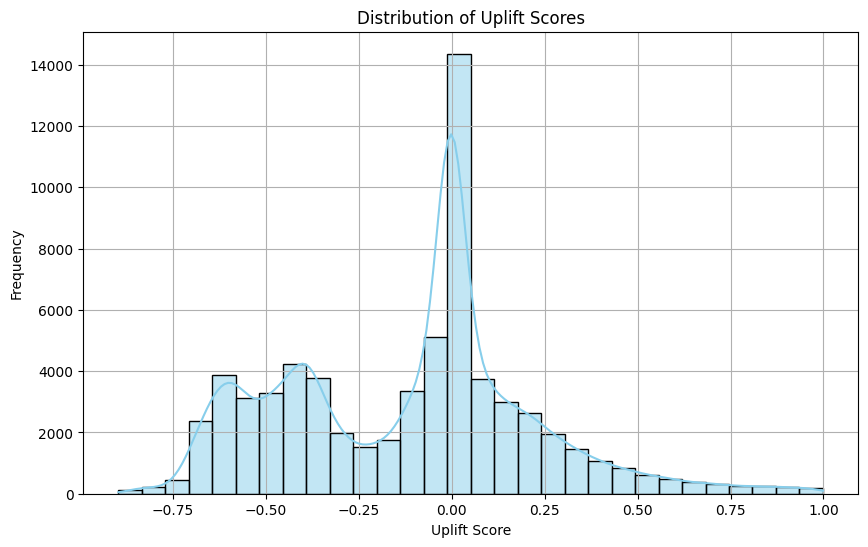

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

uplift_scores = rmf_dataset['Uplift_Score']  

plt.figure(figsize=(10,6))
sns.histplot(uplift_scores, bins=30, kde=True, color='skyblue')
plt.title("Distribution of Uplift Scores")
plt.xlabel("Uplift Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [42]:
churned_customers = rmf_dataset[rmf_dataset['Churn_Label_KNN'] == 1]

top_churned_customers = churned_customers.sort_values('Uplift_Score', ascending=False).head(10000)


In [43]:
def assign_discount(uplift):
    if uplift > 0.05:        
        return 0.25
    elif uplift > 0.03:      
        return 0.15
    elif uplift > 0.015:     
        return 0.05
    else:
        return 0.00          


In [44]:
top_churned_customers['Assigned_Discount'] = top_churned_customers['Uplift_Score'].apply(assign_discount)
top_churned_customers['Expected_Revenue_Saved'] = top_churned_customers['Monetary'] * top_churned_customers['Uplift_Score']
top_churned_customers['Discount_Cost'] = top_churned_customers['Monetary'] * top_churned_customers['Assigned_Discount']
top_churned_customers['ROI'] = top_churned_customers['Expected_Revenue_Saved'] / top_churned_customers['Discount_Cost'].replace(0, 1)


In [45]:
top_targets = top_churned_customers.sort_values(by='ROI', ascending=False).head(10000)


In [46]:
top_targets

,CUSTOMER_ID,Recency,Frequency,Monetary,Total_Units,Total_Organic_Discount,Total_Extra_Discount,Total_Discounts,AVG_ORGANIC_DISCOUNT_PER_ORDER,USED_ORGANIC_DISCOUNT_RATIO,...,FAVORITE_WEEKDAY,FAVORITE_HOUR,KNN_Distance,Churn_Label_KNN,Treatment,Uplift_Score,Assigned_Discount,Expected_Revenue_Saved,Discount_Cost,ROI
125579,8f872c865e676460aa3ea7704a107d184fa25b383a358d...,482,1,27.5000,1,7.20,0.0000,7.2000,7.20,1.0,...,Tuesday,12,2.284895,1.0,False,0.941908,0.25,25.902457,6.87500,3.767630
91148,688a1e1ef66dfd59640925e31cb4cfff84565411de0a3b...,137,1,37.8000,1,6.10,0.0000,6.1000,6.10,1.0,...,Thursday,1,2.148086,1.0,False,0.933475,0.25,35.285355,9.45000,3.733900
106855,7a586255f432a8946ee731e15ba5c9bae950bf6c94cecd...,99,1,58.7782,1,9.10,0.0118,9.1118,9.10,1.0,...,Sunday,12,2.427415,1.0,True,0.901129,0.25,52.966718,14.69455,3.604514
36765,2a929c8db43150d44af9e4666de2d5180e3cf47b405e29...,99,1,47.7882,1,7.50,0.0118,7.5118,7.50,1.0,...,Sunday,0,2.461754,1.0,True,0.895424,0.25,42.790718,11.94705,3.581697
200890,e5ebdde8612f03bb706d3ea2268c3291a932cdb12a1400...,147,1,41.6882,1,13.30,0.0118,13.3118,13.30,1.0,...,Monday,16,2.449571,1.0,True,0.887379,0.25,36.993244,10.42205,3.549517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42873,31a77ef6d38d260978233bdba5a5d0b5964ec3f260eb4e...,1099,2,113.7000,3,0.00,22.3000,22.3000,0.00,0.0,...,Monday,11,2.156341,1.0,True,0.099865,0.25,11.354661,28.42500,0.399460
16068,12af2bc5b777c00b907c97ef2fa7975529b81a68c0f14d...,548,2,101.8000,6,0.00,23.7000,23.7000,0.00,0.0,...,Monday,18,2.514597,1.0,True,0.099792,0.25,10.158825,25.45000,0.399168
221132,fd5ad5fddf5201a786a2392d0a672854d5c8cc279c400a...,169,1,63.4000,3,12.27,0.0300,12.3000,12.27,1.0,...,Sunday,13,2.201209,1.0,True,0.099746,0.25,6.323916,15.85000,0.398985
26597,1edf26c9346073b406e57dc5e761bc7e0b653466511c98...,10,1,0.0000,1,0.00,0.0000,0.0000,0.00,0.0,...,Friday,0,2.466176,1.0,False,0.689823,0.25,0.000000,0.00000,0.000000
